In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
#setting plot options
plt.rcParams['figure.figsize'] = (10, 6)
default_plot_colour = "#00bfbf"

In [3]:
#importing the relevant data
data = pd.read_csv("fake_news_data.csv")

In [4]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


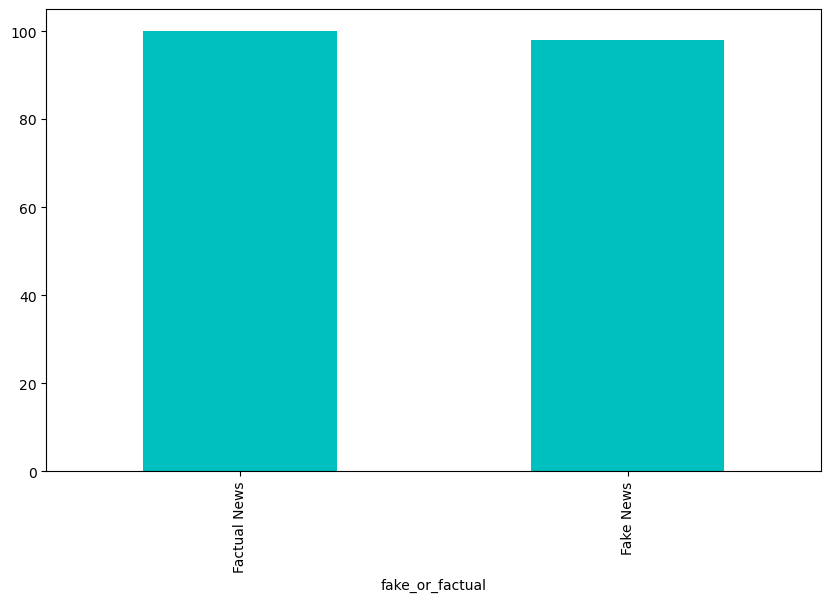

In [6]:
data['fake_or_factual'].value_counts().plot(kind='bar', color = default_plot_colour)
plt.title=("Count of Article Classification")

In [7]:
#POS Tagging

In [8]:
nlp = spacy.load('en_core_web_sm')

In [9]:
fake_news = data[data['fake_or_factual'] == "Fake News"]
fact_news = data[data['fake_or_factual'] == "Factual News"]

In [10]:
fake_spacydocs = list(nlp.pipe(fake_news['text']))
fact_spacydocs = list(nlp.pipe(fact_news['text']))

In [11]:
def extract_token_tags(doc: spacy.tokens.doc.Doc):
    return[(i.text, i.ent_type_, i.pos_) for i in doc]

In [12]:
fake_tagsdf = []
columns = ["token", "ner_tag", "pos_tag"]

In [13]:
for ix, doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc)
    tag = pd.DataFrame(tags)
    tag.columns = columns
    fake_tagsdf.append(tags)

In [14]:
print(type(fake_tagsdf))

<class 'list'>


In [15]:
for i, df in enumerate(fake_tagsdf):
    if not isinstance(df, pd.DataFrame):
        print(f"Item at index {i} is not a DataFrame: {type(df)}")

Item at index 0 is not a DataFrame: <class 'list'>
Item at index 1 is not a DataFrame: <class 'list'>
Item at index 2 is not a DataFrame: <class 'list'>
Item at index 3 is not a DataFrame: <class 'list'>
Item at index 4 is not a DataFrame: <class 'list'>
Item at index 5 is not a DataFrame: <class 'list'>
Item at index 6 is not a DataFrame: <class 'list'>
Item at index 7 is not a DataFrame: <class 'list'>
Item at index 8 is not a DataFrame: <class 'list'>
Item at index 9 is not a DataFrame: <class 'list'>
Item at index 10 is not a DataFrame: <class 'list'>
Item at index 11 is not a DataFrame: <class 'list'>
Item at index 12 is not a DataFrame: <class 'list'>
Item at index 13 is not a DataFrame: <class 'list'>
Item at index 14 is not a DataFrame: <class 'list'>
Item at index 15 is not a DataFrame: <class 'list'>
Item at index 16 is not a DataFrame: <class 'list'>
Item at index 17 is not a DataFrame: <class 'list'>
Item at index 18 is not a DataFrame: <class 'list'>
Item at index 19 is no

In [16]:
dataframes = []
for i, item in enumerate(fake_tagsdf):
    if isinstance(item, list):
        dataframes.append(pd.DataFrame(item))
    else:
        print(f"Item at index {i} is not a list: {type(item)}")


In [17]:
if dataframes:  # Check if there are any DataFrames to concatenate
    combined_df = pd.concat(dataframes, ignore_index=True)
else:
    combined_df = pd.DataFrame()

In [18]:
print(combined_df.head())

          0         1     2
0     There            PRON
1       are            VERB
2       two  CARDINAL   NUM
3     small             ADJ
4  problems            NOUN


In [19]:
for i, item in enumerate(fake_tagsdf):
    print(f"Item at index {i}: {item} (Type: {type(item)})")

Item at index 0: [('There', '', 'PRON'), ('are', '', 'VERB'), ('two', 'CARDINAL', 'NUM'), ('small', '', 'ADJ'), ('problems', '', 'NOUN'), ('with', '', 'ADP'), ('your', '', 'PRON'), ('analogy', '', 'NOUN'), ('Susan', 'PERSON', 'PROPN'), (' ', 'PERSON', 'SPACE'), ('Jesus', 'PERSON', 'PROPN'), ('was', '', 'AUX'), ('NOT', '', 'PART'), ('a', '', 'DET'), ('Muslim', 'NORP', 'PROPN'), ('and', '', 'CCONJ'), ('Joseph', 'PERSON', 'PROPN'), ('traveled', '', 'VERB'), ('to', '', 'ADP'), ('Bethlehem', 'ORG', 'PROPN'), ('with', '', 'ADP'), ('Mary', 'PERSON', 'PROPN'), ('.', '', 'PUNCT'), ('For', '', 'ADP'), ('anyone', '', 'PRON'), ('who', '', 'PRON'), ('s', '', 'AUX'), ('not', '', 'PART'), ('paying', '', 'VERB'), ('attention', '', 'NOUN'), ('there', '', 'ADV'), ('don', 'PERSON', 'PROPN'), ('t', '', 'PROPN'), ('appear', '', 'VERB'), ('to', '', 'PART'), ('be', '', 'AUX'), ('many', '', 'ADJ'), ('female', '', 'ADJ'), ('refugees', '', 'NOUN'), ('accompanying', '', 'VERB'), ('male', '', 'ADJ'), ('Muslim', '

In [20]:
dataframes = []
for i, item in enumerate(fake_tagsdf):
    if isinstance(item, list):
        try:
            # Converting the list to a DataFrame
            df = pd.DataFrame(item)
            dataframes.append(df)
        except Exception as e:
            print(f"Error converting item at index {i}: {e}")
    else:
        print(f"Item at index {i} is not a list: {type(item)}")


In [21]:
print([type(df) for df in dataframes])

[<class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.fram

In [22]:
if dataframes:  # Ensuring that there are DataFrames to concatenate
    combined_df = pd.concat(dataframes, ignore_index=True)
else:
    combined_df = pd.DataFrame()

In [23]:
print(combined_df.head())

          0         1     2
0     There            PRON
1       are            VERB
2       two  CARDINAL   NUM
3     small             ADJ
4  problems            NOUN


In [24]:
fake_tagsdf = []  # Initializing as an empty list
for doc in fake_spacydocs:
    token_tags = extract_token_tags(doc)
    # Converting the list of tuples to a DataFrame and append it
    df = pd.DataFrame(token_tags, columns=columns)
    fake_tagsdf.append(df)

In [25]:
if fake_tagsdf:  # Ensuring the list is not empty
    combined_fake_tagsdf = pd.concat(fake_tagsdf, ignore_index=True)
else:
    combined_fake_tagsdf = pd.DataFrame()  # Creating an empty DataFrame if no data was collected

In [26]:
print(combined_fake_tagsdf.head())

      token   ner_tag pos_tag
0     There              PRON
1       are              VERB
2       two  CARDINAL     NUM
3     small               ADJ
4  problems              NOUN


In [27]:
fake_tagsdf = pd.concat(fake_tagsdf)

In [28]:
fact_tagsdf = []

In [29]:
for doc in fact_spacydocs:
    token_tags = extract_token_tags(doc)
    df = pd.DataFrame(token_tags, columns=columns)
    fact_tagsdf.append(df)

In [30]:
if fact_tagsdf:
    combined_fact_tagsdf = pd.concat(fact_tagsdf, ignore_index=True)
else:
    combined_fact_tagsdf = pd.DataFrame() 

In [31]:
print(combined_fact_tagsdf.head())

        token ner_tag pos_tag
0  WASHINGTON     GPE   PROPN
1           (           PUNCT
2     Reuters     ORG   PROPN
3           )           PUNCT
4           -           PUNCT


In [32]:
pos_counts_fake = fake_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name="counts").sort_values(by="counts", ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
28,",",PUNCT,1908
7446,the,DET,1834
39,.,PUNCT,1531
5759,of,ADP,922
2661,and,CCONJ,875
2446,a,DET,804
0,,SPACE,795
7523,to,PART,767
4915,in,ADP,667
5094,is,AUX,419


In [33]:
if fact_tagsdf:
    combined_fact_tagsdf = pd.concat(fact_tagsdf, ignore_index=True)
else:
    combined_fact_tagsdf = pd.DataFrame()

In [34]:
pos_counts_fact = combined_fact_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name="counts").sort_values(by="counts", ascending=False)

In [35]:
pos_counts_fact.head(10)

,token,pos_tag,counts
6169,the,DET,1903
15,",",PUNCT,1698
22,.,PUNCT,1381
4733,of,ADP,884
1905,a,DET,789
2100,and,CCONJ,757
4015,in,ADP,672
6230,to,PART,660
4761,on,ADP,482
5586,said,VERB,452


In [36]:
pos_counts_fake[pos_counts_fake.pos_tag == "NOUN"][:15]

,token,pos_tag,counts
5969,people,NOUN,77
7959,women,NOUN,55
6204,president,NOUN,53
7511,time,NOUN,52
8011,year,NOUN,44
3134,campaign,NOUN,44
4577,government,NOUN,41
5208,law,NOUN,40
7344,t,NOUN,40
8013,years,NOUN,40


In [37]:
pos_counts_fake[pos_counts_fake.pos_tag == "VERB"][:15]

,token,pos_tag,counts
6766,said,VERB,144
6754,s,VERB,143
4698,have,VERB,78
5167,know,VERB,54
7529,told,VERB,49
5387,made,VERB,45
4640,had,VERB,43
4558,go,VERB,40
4561,going,VERB,40
6788,say,VERB,34


In [38]:
pos_counts_fake[pos_counts_fake.pos_tag == "ADV"][:15]

,token,pos_tag,counts
5142,just,ADV,68
2638,also,ADV,56
4138,even,ADV,53
7045,so,ADV,47
5730,now,ADV,44
7773,very,ADV,39
5803,only,ADV,34
2764,as,ADV,33
7453,then,ADV,28
2855,back,ADV,27


In [39]:
pos_counts_fake[pos_counts_fake.pos_tag == "PROPN"][:15]

,token,pos_tag,counts
2236,Trump,PROPN,313
693,Clinton,PROPN,119
7345,t,PROPN,98
839,Donald,PROPN,75
1652,Obama,PROPN,69
1791,President,PROPN,68
1100,Hillary,PROPN,64
1475,McCain,PROPN,53
411,America,PROPN,49
2128,Syria,PROPN,42


In [40]:
pos_counts_fake[pos_counts_fake.pos_tag == "ADJ"][:15]

,token,pos_tag,counts
5577,more,ADJ,52
5844,other,ADJ,49
5431,many,ADJ,43
30,-,ADJ,35
6108,political,ADJ,34
1899,Republican,ADJ,33
4431,former,ADJ,31
4296,federal,ADJ,29
6772,same,ADJ,27
4372,first,ADJ,27


In [41]:
pos_counts_fact[pos_counts_fact.pos_tag == "NOUN"][:15]

,token,pos_tag,counts
3748,government,NOUN,71
6639,year,NOUN,64
5927,state,NOUN,58
2373,bill,NOUN,55
1982,administration,NOUN,51
3289,election,NOUN,48
5084,president,NOUN,47
4804,order,NOUN,45
4937,people,NOUN,45
2509,campaign,NOUN,42


In [42]:
pos_counts_fact[pos_counts_fact.pos_tag == "VERB"][:15]

,token,pos_tag,counts
5586,said,VERB,452
6235,told,VERB,55
3851,have,VERB,43
6667,’s,VERB,35
4031,including,VERB,33
4425,make,VERB,31
4410,made,VERB,29
6096,take,VERB,28
3181,do,VERB,26
5601,saying,VERB,24


In [43]:
pos_counts_fact[pos_counts_fact.pos_tag == "ADV"][:15]

,token,pos_tag,counts
2078,also,ADV,69
2206,as,ADV,21
6552,well,ADV,20
4773,only,ADV,20
6428,very,ADV,20
5820,so,ADV,18
4585,most,ADV,17
2077,already,ADV,17
4705,now,ADV,17
3398,even,ADV,17


In [44]:
pos_counts_fact[pos_counts_fact.pos_tag == "PROPN"][:15]

,token,pos_tag,counts
1746,Trump,PROPN,240
1766,U.S.,PROPN,177
1480,Reuters,PROPN,131
1424,President,PROPN,89
912,House,PROPN,72
1783,United,PROPN,69
1644,States,PROPN,56
1327,Obama,PROPN,56
663,Donald,PROPN,50
1844,White,PROPN,48


In [45]:
pos_counts_fact[pos_counts_fact.pos_tag == "ADJ"][:15]

,token,pos_tag,counts
3641,former,ADJ,50
4814,other,ADJ,49
4580,more,ADJ,45
4522,military,ADJ,43
5023,political,ADJ,43
4260,last,ADJ,38
5086,presidential,ADJ,34
4666,new,ADJ,33
1470,Republican,ADJ,32
1512,Russian,ADJ,28


In [46]:
# NAMED ENTITIES

In [47]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != " "].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [48]:
# Ensure fake_tagsdf is initialized as a list of DataFrames
fake_tagsdf = []  # Initialize as an empty list before collecting DataFrames

# Your code to populate fake_tagsdf with DataFrames should be here

# Check if the list is not empty
if fake_tagsdf:  # This checks if the list has any DataFrames
    combined_fake_tagsdf = pd.concat(fake_tagsdf, ignore_index=True)
else:
    combined_fake_tagsdf = pd.DataFrame()  # Create an empty DataFrame if no data was collected


In [49]:
if fake_tagsdf:  # fake is a list and I need a dataframe so I am checking if the list is not empty
    combined_fake_tagsdf = pd.concat(fake_tagsdf, ignore_index=True)
else:
    combined_fake_tagsdf = pd.DataFrame()  # Creating an empty DataFrame if no data was collected

In [51]:
# Create DataFrame with appropriate columns
fake_tagsdf = []  # Initialize an empty list to collect DataFrames
for doc in fake_spacydocs:
    tags = extract_token_tags(doc)  # This should return a list of (token, ner_tag, pos_tag)
    df = pd.DataFrame(tags, columns=["token", "ner_tag", "pos_tag"])
    fake_tagsdf.append(df)

# After collecting all DataFrames, concatenate
if fake_tagsdf:
    combined_fake_tagsdf = pd.concat(fake_tagsdf, ignore_index=True)
else:
    combined_fake_tagsdf = pd.DataFrame()  # Empty DataFrame if no data

# Now perform your grouping
if 'ner_tag' in combined_fake_tagsdf.columns:
    top_entities_fake = (
        combined_fake_tagsdf[combined_fake_tagsdf['ner_tag'] != " "]
        .groupby(['token', 'ner_tag'])
        .size()
        .reset_index(name='counts')
        .sort_values(by='counts', ascending=False)
    )
else:
    print("ner_tag column is missing from combined_fake_tagsdf")


In [53]:
ner_palette = {
    'ORG': sns.color_palette ("Set2").as_hex()[0],
    'GPE': sns.color_palette ("Set2").as_hex()[1],
    'NORP': sns.color_palette ("Set2").as_hex()[2],
    'PERSON': sns.color_palette ("Set2").as_hex()[3],
    'DATE': sns.color_palette ("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette ("Set2").as_hex()[5],
    'PERCENT': sns.color_palette ("Set2").as_hex()[6]
}

In [55]:
top_entities_fake = top_entities_fake[top_entities_fake['ner_tag'].str.strip() != ""]

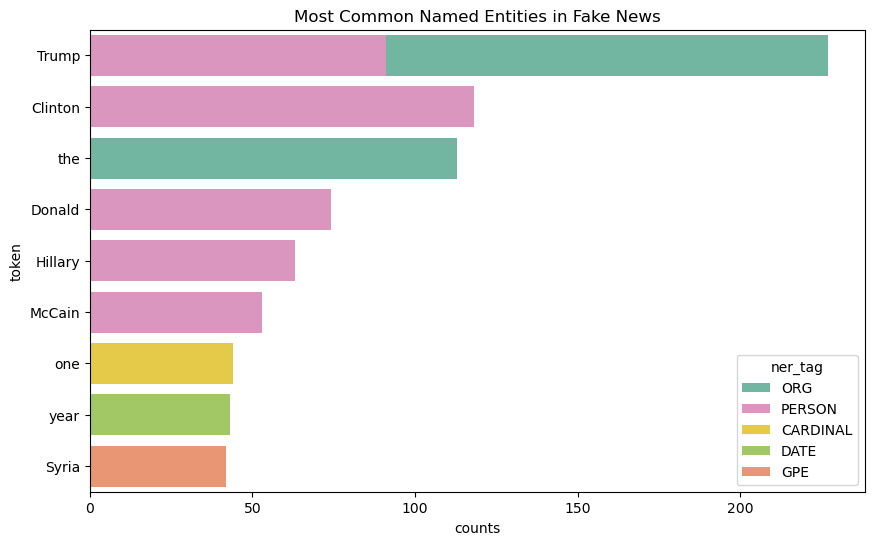

In [57]:
sns.barplot(
    x='counts',
    y='token',
    hue='ner_tag',
    palette=ner_palette,
    data=top_entities_fake[:10],
    orient='h',
    dodge=False
).set(title = "Most Common Named Entities in Fake News")
plt.show()

In [61]:
fact_tagsdf = []  # Initialize as an empty list to collect DataFrames

# Example: Assuming you have a loop or function that fills this list
for doc in fact_spacydocs:
    tags = extract_token_tags(doc)  # Get tokens, ner_tags, pos_tags
    df = pd.DataFrame(tags, columns=["token", "ner_tag", "pos_tag"])
    fact_tagsdf.append(df)

# After populating, concatenate into a single DataFrame
if fact_tagsdf:
    combined_fact_tagsdf = pd.concat(fact_tagsdf, ignore_index=True)
else:
    combined_fact_tagsdf = pd.DataFrame()  # Create an empty DataFrame if no data was collected


In [63]:
top_entities_fact = (
    combined_fact_tagsdf[combined_fact_tagsdf['ner_tag'] != " "]
    .groupby(['token', 'ner_tag'])
    .size()
    .reset_index(name='counts')
    .sort_values(by='counts', ascending=False)
)

In [67]:
print(combined_fact_tagsdf.columns)
print(combined_fact_tagsdf.head())

Index(['token', 'ner_tag', 'pos_tag'], dtype='object')
        token ner_tag pos_tag
0  WASHINGTON     GPE   PROPN
1           (           PUNCT
2     Reuters     ORG   PROPN
3           )           PUNCT
4           -           PUNCT


In [71]:
top_entities_fact = (
    combined_fact_tagsdf[combined_fact_tagsdf['ner_tag'] != " "]  # Ensure you're checking for valid ner_tag values
    .groupby(['token', 'ner_tag'])
    .size()
    .reset_index(name='counts')
    .sort_values(by='counts', ascending=False)
)

In [77]:
top_entities_fact = top_entities_fact[top_entities_fact['ner_tag'].str.strip() != ""]

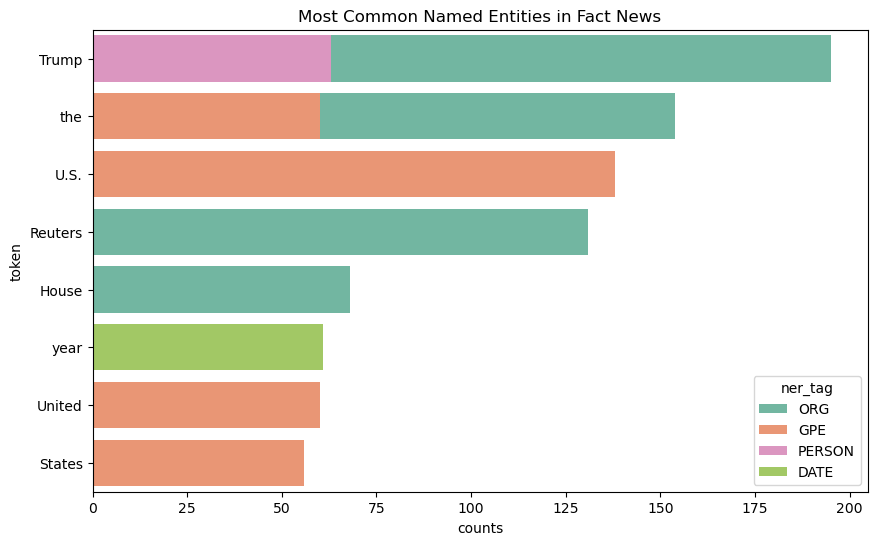

In [79]:
sns.barplot(
    x='counts',
    y='token',
    hue='ner_tag',
    palette=ner_palette,
    data=top_entities_fact[:10],
    orient='h',
    dodge=False
).set(title = "Most Common Named Entities in Fact News")
plt.show()

In [ ]:
# TEXT PRE PROCESSING

In [81]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [85]:
data['text_clean'] = data.apply (lambda x: re.sub(r"^[^-]*-\s", " ", x['text']), axis=1)

In [87]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,There are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,Buried in Trump s bonkers interview with New Y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"Women make up over 50 percent of this country,..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,U.S. Defense Secretary Jim Mattis said on Mon...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,Northern Ireland s political parties are rapi...


In [89]:
data['text_clean'] = data['text_clean'].str.lower()

In [91]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,there are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"women make up over 50 percent of this country,..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,u.s. defense secretary jim mattis said on mon...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapi...


In [95]:
en_stopwords = stopwords.words('english')
print(en_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [103]:
data['text_clean'] = data['text_clean'].apply (lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

In [105]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,two small problems analogy susan jesus muslim ...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried trump bonkers interview new york times ...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"women make 50 percent country, grossly underre..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,u.s. defense secretary jim mattis said monday ...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland political parties rapidly run...


In [109]:
data['text_clean'] =  data.apply (lambda x: word_tokenize (x['text_clean']), axis=1)

In [115]:
lemmatizer = WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [117]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, ,, grossly..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u.s., defense, secretary, jim, mattis, said, ..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [119]:
tokens_clean = sum(data['text_clean'], [])

In [121]:
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts())
print(unigrams)

(,,)               3597
(.,)               2361
(trump,)            584
(said,)             580
(’,)                378
                   ... 
(sexism,)             1
(/,)                  1
(1978,)               1
(cancellation,)       1
(petrosyan,)          1
Name: count, Length: 9249, dtype: int64


In [131]:
unigrams.index = [idx[0] for idx in unigrams.index]

[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

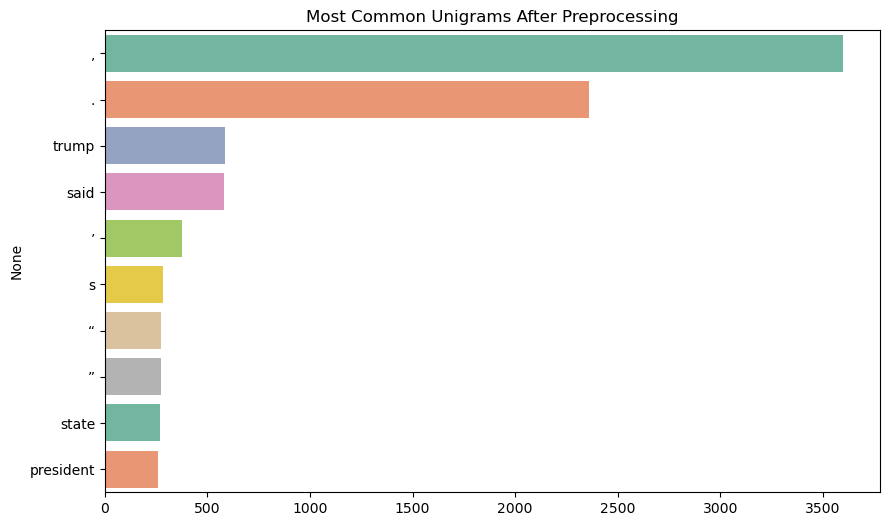

In [157]:
palette = sns.color_palette("Set2", n_colors=10)

sns.barplot(x=unigrams.values[:10],
            y=unigrams.index[:10],
            hue=unigrams.index[:10],
            orient = 'h',
            palette = palette,
            legend=False 
           ).set(title = "Most Common Unigrams After Preprocessing")

In [135]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts())
print(bigrams)

(’, s)                     283
(., “)                     156
(,, said)                  138
(,, ”)                     121
(said, .)                  119
                          ... 
(previously, confirmed)      1
(official, previously)       1
(leak, .)                    1
(investigation, leak)        1
(campus, reform)             1
Name: count, Length: 39475, dtype: int64


In [139]:
bigrams.index = [idx[0] for idx in bigrams.index]

[Text(0.5, 1.0, 'Most Common Bigrams After Preprocessing')]

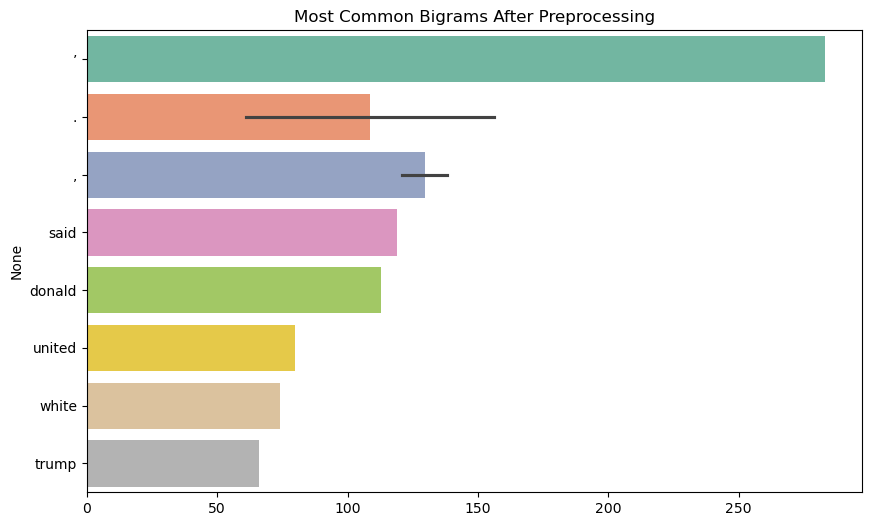

In [165]:
palette = sns.color_palette("Set2", n_colors=8)

sns.barplot(x=bigrams.values[:10],
            y=bigrams.index[:10],
            hue=bigrams.index[:10], 
            palette="Set2",  
            orient='h',
            legend=False 
           ).set(title="Most Common Bigrams After Preprocessing")

In [ ]:
# SENTIMENT ANALYSIS

In [169]:
vader_sentiment = SentimentIntensityAnalyzer()

In [173]:
data['vader_sentiment_score'] = data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])

In [175]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, ,, grossly...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u.s., defense, secretary, jim, mattis, said, ...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [179]:
bins = [-1, -0.1, 0.1, 1]
names = ['negative','neutral','positive']

In [189]:
data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

In [191]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader-sentiment_label,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, ,, grossly...",0.9779,positive,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u.s., defense, secretary, jim, mattis, said, ...",-0.3400,negative,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive,positive


<Axes: xlabel='vader_sentiment_label'>

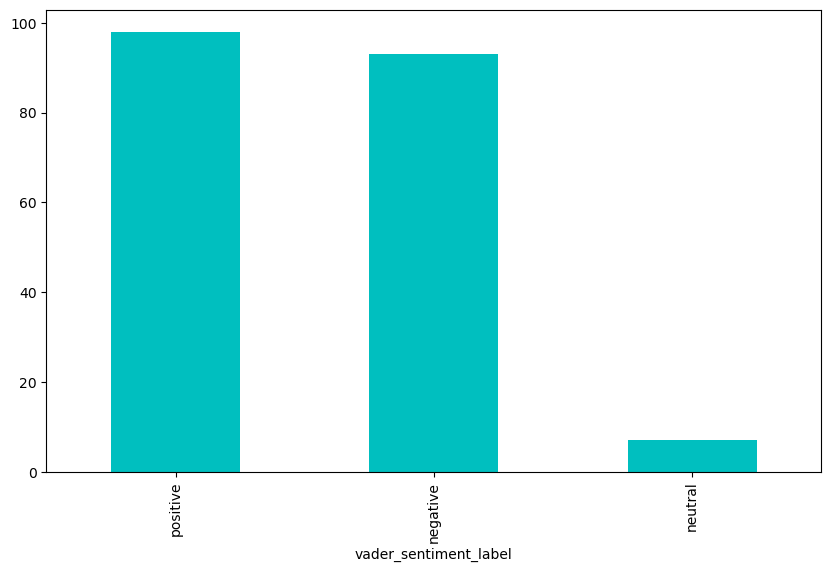

In [193]:
data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_colour)

[Text(0.5, 1.0, 'Sentiment by News Type')]

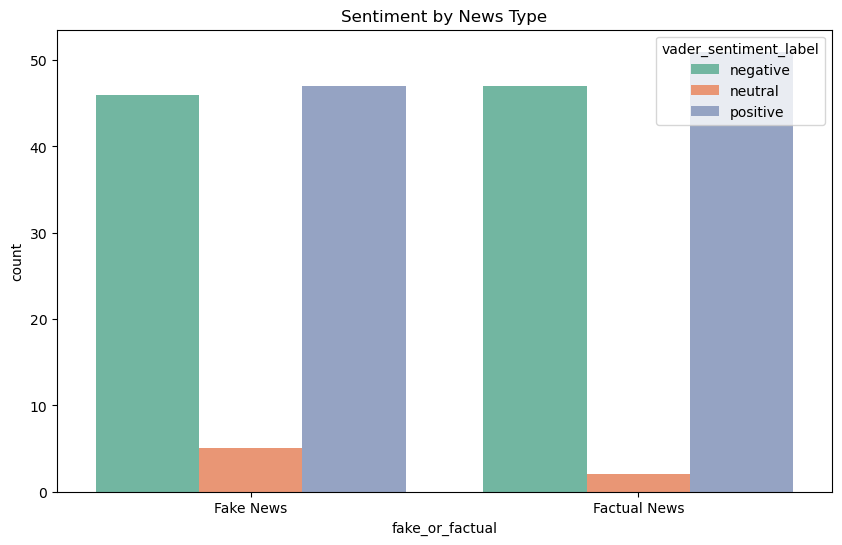

In [199]:
palette = sns.color_palette("Set2", n_colors=3)

sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette = palette,
    data = data
).set(title= "Sentiment by News Type")

In [ ]:
# TOPIC MODELLING

In [203]:
fake_news_text = data[data['fake_or_factual'] == "Fake News"]['text_clean'].reset_index(drop=True)

In [205]:
dictionary_fake = corpora.Dictionary(fake_news_text)

In [209]:
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

In [224]:
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics_i, id2word=dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

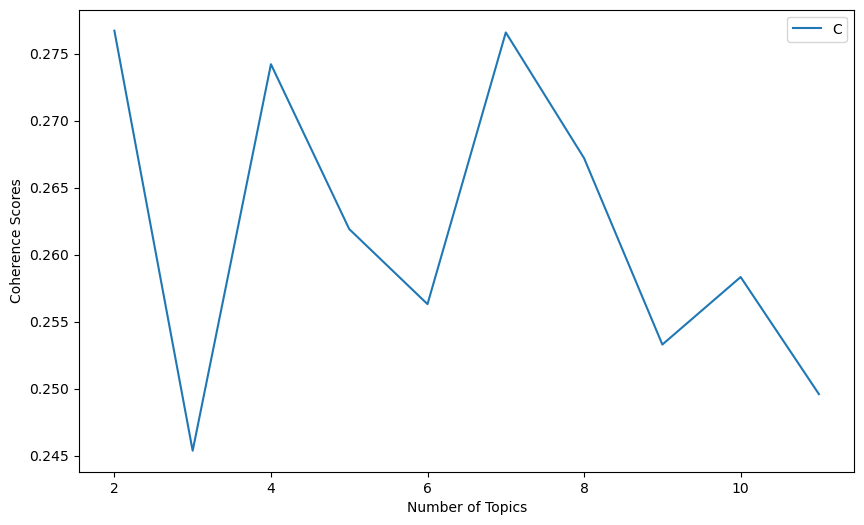

In [244]:
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Scores")
plt.legend(("Coherence_Values"), loc='best')

In [234]:
num_topics_lda = 7
lda_model = gensim.models.LdaModel(corpus=doc_term_fake, id2word=dictionary_fake, num_topics=num_topics_lda)

In [236]:
lda_model.print_topics(num_topics_lda, num_words=10)

[(0,
  '0.007*"," + 0.006*"." + 0.004*"trump" + 0.002*":" + 0.002*"clinton" + 0.001*"email" + 0.001*"food" + 0.001*"supporter" + 0.001*"republican" + 0.001*"state"'),
 (1,
  '0.043*"," + 0.033*"." + 0.020*"trump" + 0.007*":" + 0.006*")" + 0.005*"?" + 0.005*"(" + 0.004*"@" + 0.003*"donald" + 0.003*"would"'),
 (2,
  '0.071*"," + 0.038*"." + 0.007*":" + 0.006*"trump" + 0.005*"clinton" + 0.005*"president" + 0.004*"u" + 0.004*"(" + 0.004*")" + 0.004*"would"'),
 (3,
  '0.054*"," + 0.027*"." + 0.009*"trump" + 0.005*":" + 0.005*"!" + 0.004*"(" + 0.004*")" + 0.004*"?" + 0.004*"clinton" + 0.003*"said"'),
 (4,
  '0.051*"," + 0.019*"." + 0.005*"clinton" + 0.005*":" + 0.004*"state" + 0.003*"trump" + 0.003*")" + 0.003*"would" + 0.003*"(" + 0.003*"said"'),
 (5,
  '0.068*"," + 0.042*"." + 0.012*"trump" + 0.008*":" + 0.006*"said" + 0.005*"president" + 0.005*"state" + 0.004*"?" + 0.004*"one" + 0.003*"time"'),
 (6,
  '0.037*"," + 0.023*"." + 0.009*"trump" + 0.006*":" + 0.004*"one" + 0.004*"said" + 0.003*

In [ ]:
# LATENT SEMANTIC ANALYSIS

In [240]:
def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus = doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [242]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    coherence_values = []
    model_list = []
    for num_topics_i in range (min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics = num_topics_i, id2word=dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

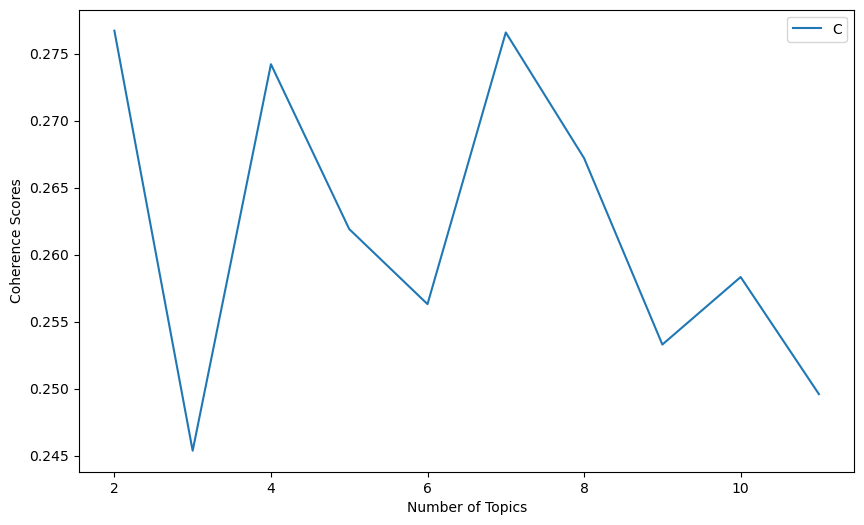

In [246]:
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Scores")
plt.legend(("Coherence_Values"), loc='best')
plt.show()

In [248]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

In [250]:
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [254]:
lsa_model = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=7)

In [256]:
lsa_model.print_topics()

[(0,
  '0.182*"trump" + 0.128*"clinton" + 0.090*"obama" + 0.089*"hillary" + 0.085*"president" + 0.082*"woman" + 0.081*"boiler" + 0.080*"," + 0.079*"flynn" + 0.074*"@"'),
 (1,
  '0.333*"boiler" + 0.272*"acr" + 0.248*"pm" + 0.232*"room" + 0.179*"broadcast" + 0.172*"radio" + 0.146*"|" + 0.137*"animal" + 0.137*"tune" + 0.129*"jay"'),
 (2,
  '-0.596*"flynn" + -0.174*"immunity" + -0.160*"@" + -0.117*"nana" + -0.110*"march" + -0.103*"30" + -0.092*"mr." + 0.089*"school" + -0.086*"michael" + -0.086*"adviser"'),
 (3,
  '0.230*"clinton" + -0.176*"school" + -0.161*"student" + 0.148*"hillary" + -0.118*"county" + 0.111*"sander" + 0.098*"debate" + 0.096*"woman" + 0.092*"nominee" + 0.086*"candidate"'),
 (4,
  '-0.161*"trump" + 0.157*"email" + -0.137*"@" + -0.120*"#" + -0.118*"vote" + 0.116*"clinton" + -0.114*"november" + 0.112*"student" + -0.111*"8" + -0.107*"cruz"'),
 (5,
  '-0.266*"student" + -0.161*"school" + 0.130*"mccain" + -0.129*"conference" + -0.128*"trump" + 0.116*"putin" + 0.114*"obama" + 0.

In [ ]:
# CREATING A CLASSIFICATION MODEL

In [260]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader-sentiment_label,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, ,, grossly...",0.9779,positive,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u.s., defense, secretary, jim, mattis, said, ...",-0.3400,negative,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive,positive


In [270]:
X = [','.join(map(str,l)) for l in data['text_clean']]

In [272]:
Y = data['fake_or_factual']

In [274]:
countvec = CountVectorizer()

In [278]:
countvec_fit = countvec.fit_transform(X)

In [280]:
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns=countvec.get_feature_names_out())

In [282]:
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)

In [286]:
lr = LogisticRegression(random_state = 0).fit(X_train, y_train)

In [288]:
y_pred_lr = lr.predict(X_test)

In [290]:
accuracy_score(y_pred_lr, y_test)

0.9

In [292]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.83      1.00      0.91        29
   Fake News       1.00      0.81      0.89        31

    accuracy                           0.90        60
   macro avg       0.91      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60



In [294]:
svm = SGDClassifier().fit(X_train, y_train)

In [298]:
y_pred_svm = svm.predict(X_test)

In [300]:
accuracy_score(y_pred_svm, y_test)

0.8833333333333333

In [302]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.82      0.97      0.89        29
   Fake News       0.96      0.81      0.88        31

    accuracy                           0.88        60
   macro avg       0.89      0.89      0.88        60
weighted avg       0.89      0.88      0.88        60

